# TREE-BASED METHODS

In [66]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

In [67]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
# 0) Librerie
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (confusion_matrix, classification_report,
                             RocCurveDisplay, roc_auc_score)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Modelli tree‑based per classificazione
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, mean_squared_error
import seaborn as sns


np.random.seed(11)              # stesso seed dell’esercitazione


In [68]:
df=pd.read_csv('Data/aircraft_price_clean.csv')
np.random.seed(11) 

In [69]:

# ==== TARGET BINARIO =========================================
thr = df["price"].median()      # oppure un valore fisso, es. 2_000_000
df["high_price"] = (df["price"] > thr).astype(int)

y  = df["high_price"]
X  = df.drop(columns=["price", "high_price"])   # la price continua a esistere ma non va in X


In [70]:
cat_cols = X.select_dtypes(include=["object", "category"]).columns
num_cols = X.select_dtypes(exclude=["object", "category"]).columns


preprocess = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="passthrough"
)


In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=11
)


              precision    recall  f1-score   support

           0      0.899     0.932     0.915       133
           1      0.922     0.884     0.903       121

    accuracy                          0.909       254
   macro avg      0.910     0.908     0.909       254
weighted avg      0.910     0.909     0.909       254

[[124   9]
 [ 14 107]]
AUC: 0.927


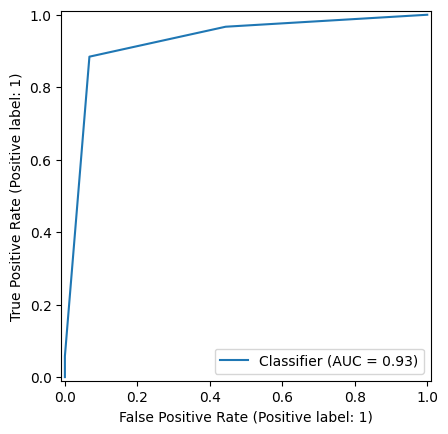

In [72]:
tree_clf = Pipeline([
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(
        criterion="gini",        # o "entropy"
        max_depth=3,             # limita l’overfitting
        class_weight="balanced", # utile se le classi sono sbilanciate
        random_state=11
    ))
]).fit(X_train, y_train)

# Valutazione
y_pred = tree_clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
conf = confusion_matrix(y_test, y_pred)
print(conf)

# ROC‑AUC
y_score = tree_clf.predict_proba(X_test)[:,1]
print("AUC:", roc_auc_score(y_test, y_score).round(3))
RocCurveDisplay.from_predictions(y_test, y_score)
plt.show()


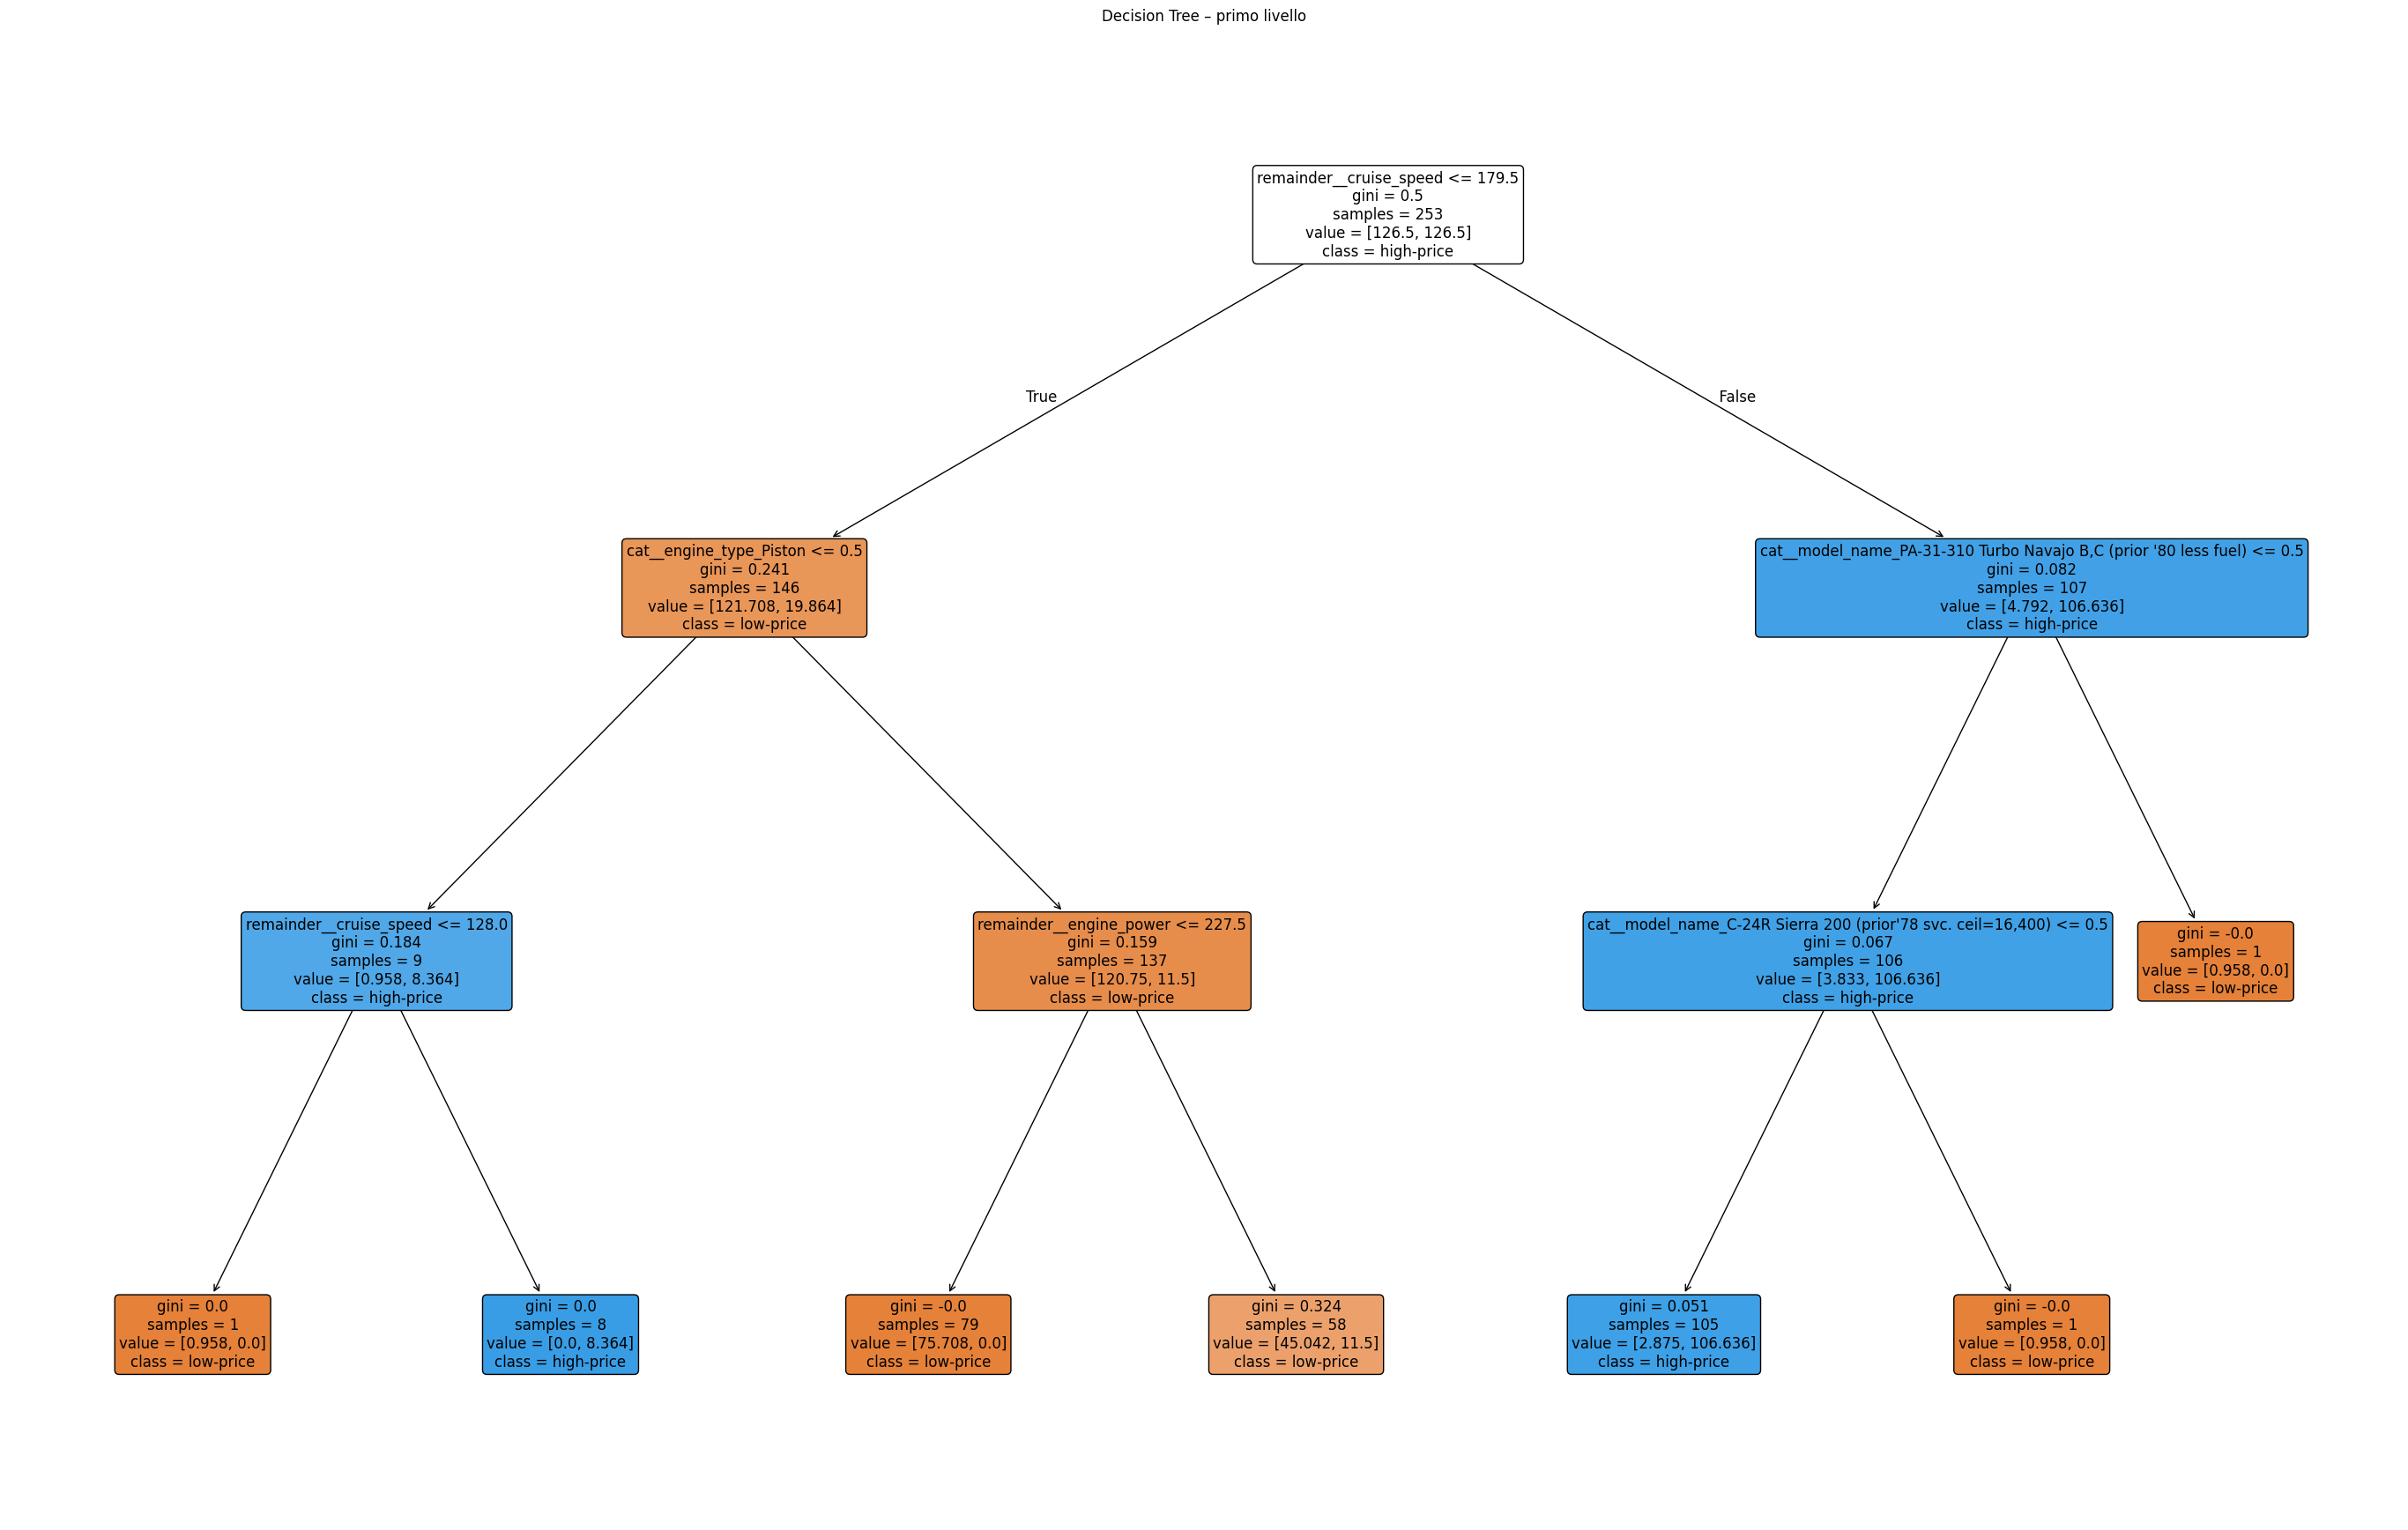

In [73]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Estrae l'albero e la lista completa delle feature (numeriche + one-hot)
estimator     = tree_clf.named_steps["clf"]
feature_names = tree_clf.named_steps["prep"].get_feature_names_out()

plt.figure(figsize=(35, 22))
plot_tree(
    estimator,
    feature_names = feature_names,
    class_names   = ["low-price", "high-price"],
    filled        = True,
    rounded       = True,
    fontsize      = 12,)
plt.title("Decision Tree – primo livello")
plt.show()



## Fitting Regression Trees

In [74]:

numeric_features = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_features]
model = MS(df_numeric.columns.drop('price'), intercept=False)
D = model.fit_transform(df_numeric)
feature_names = list(D.columns)
X = np.asarray(D)

In [75]:

(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                df_numeric['price'],
                                test_size=0.3,
                                random_state=0)


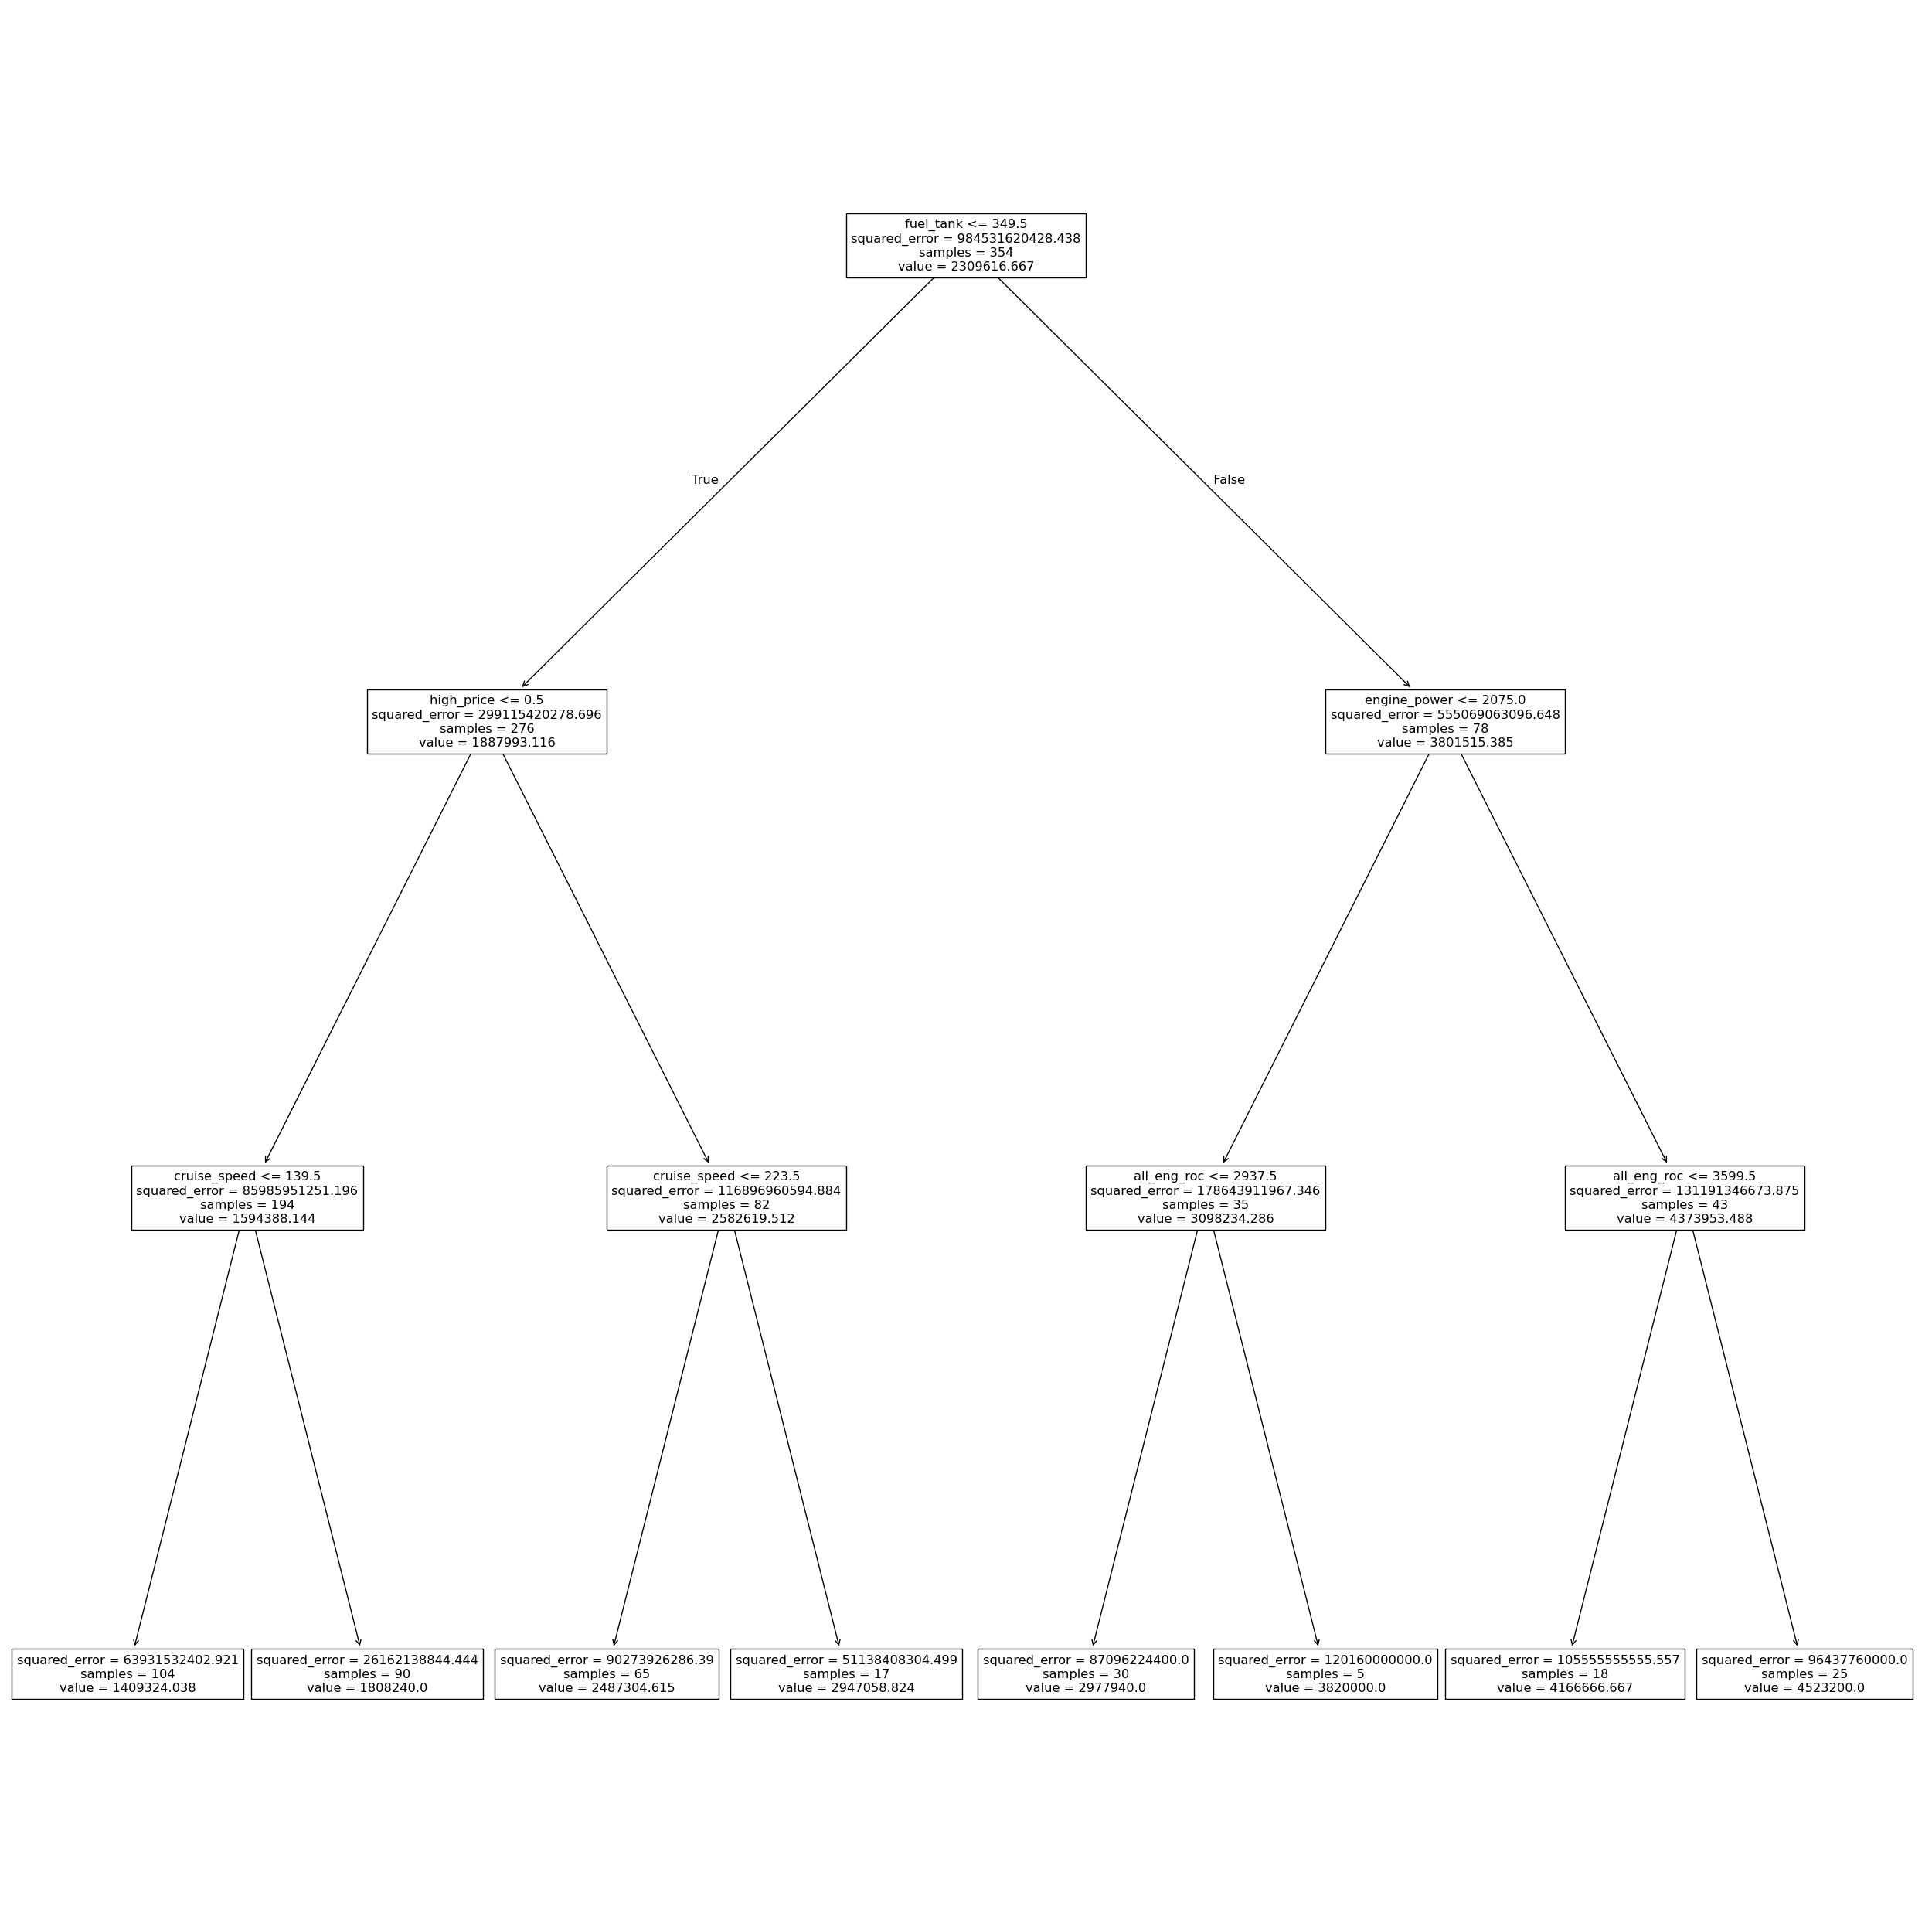

In [76]:

reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(32,32))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

          

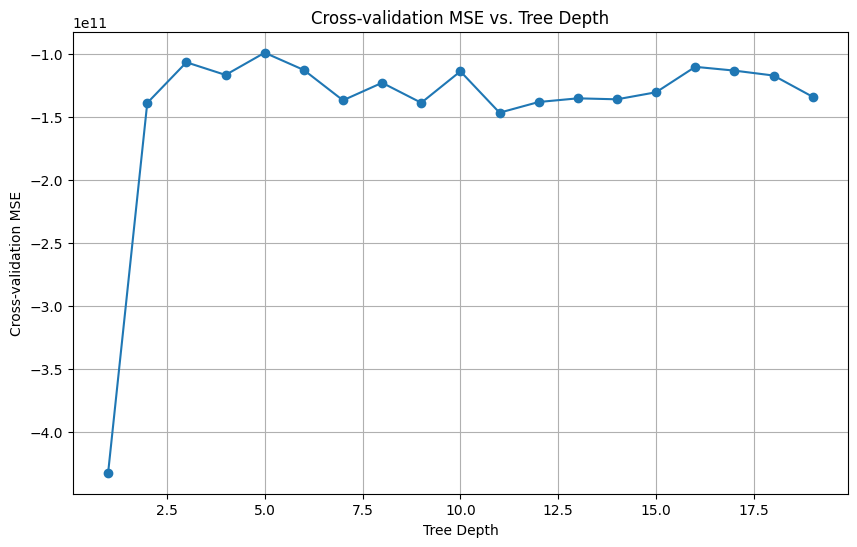

Cross-validation RMSE scores: [323945.98112733 379798.63779567 331179.18281552 237638.96124388
 311200.76053739 207739.08866596 447362.69400063 247214.04114487
 246812.0524485  385931.73263624]
Mean RMSE: 311882.31324160006


In [77]:
# Cross-validation for pruning (finding optimal tree complexity)
max_depth_values = range(1, 20)
cv_scores = []

for depth in max_depth_values:
    tree_cv = DecisionTreeRegressor(max_depth=depth, random_state=2)
    scores = cross_val_score(tree_cv, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    cv_scores.append(np.mean(scores))

# Plotting the cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, cv_scores, marker='o')
plt.title('Cross-validation MSE vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Cross-validation MSE')
plt.grid()
plt.show()

#Cross Validation RMSE
cv_scores = cross_val_score(reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-cv_scores)
print("Cross-validation RMSE scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())

     

In [78]:
# Prune the tree (select best max_depth)
best_depth = max_depth_values[np.argmax(cv_scores)]
print(f"Best depth from cross-validation: {best_depth}")

Best depth from cross-validation: 6


MSE:  78679365570.28
RMSE: 280498.42


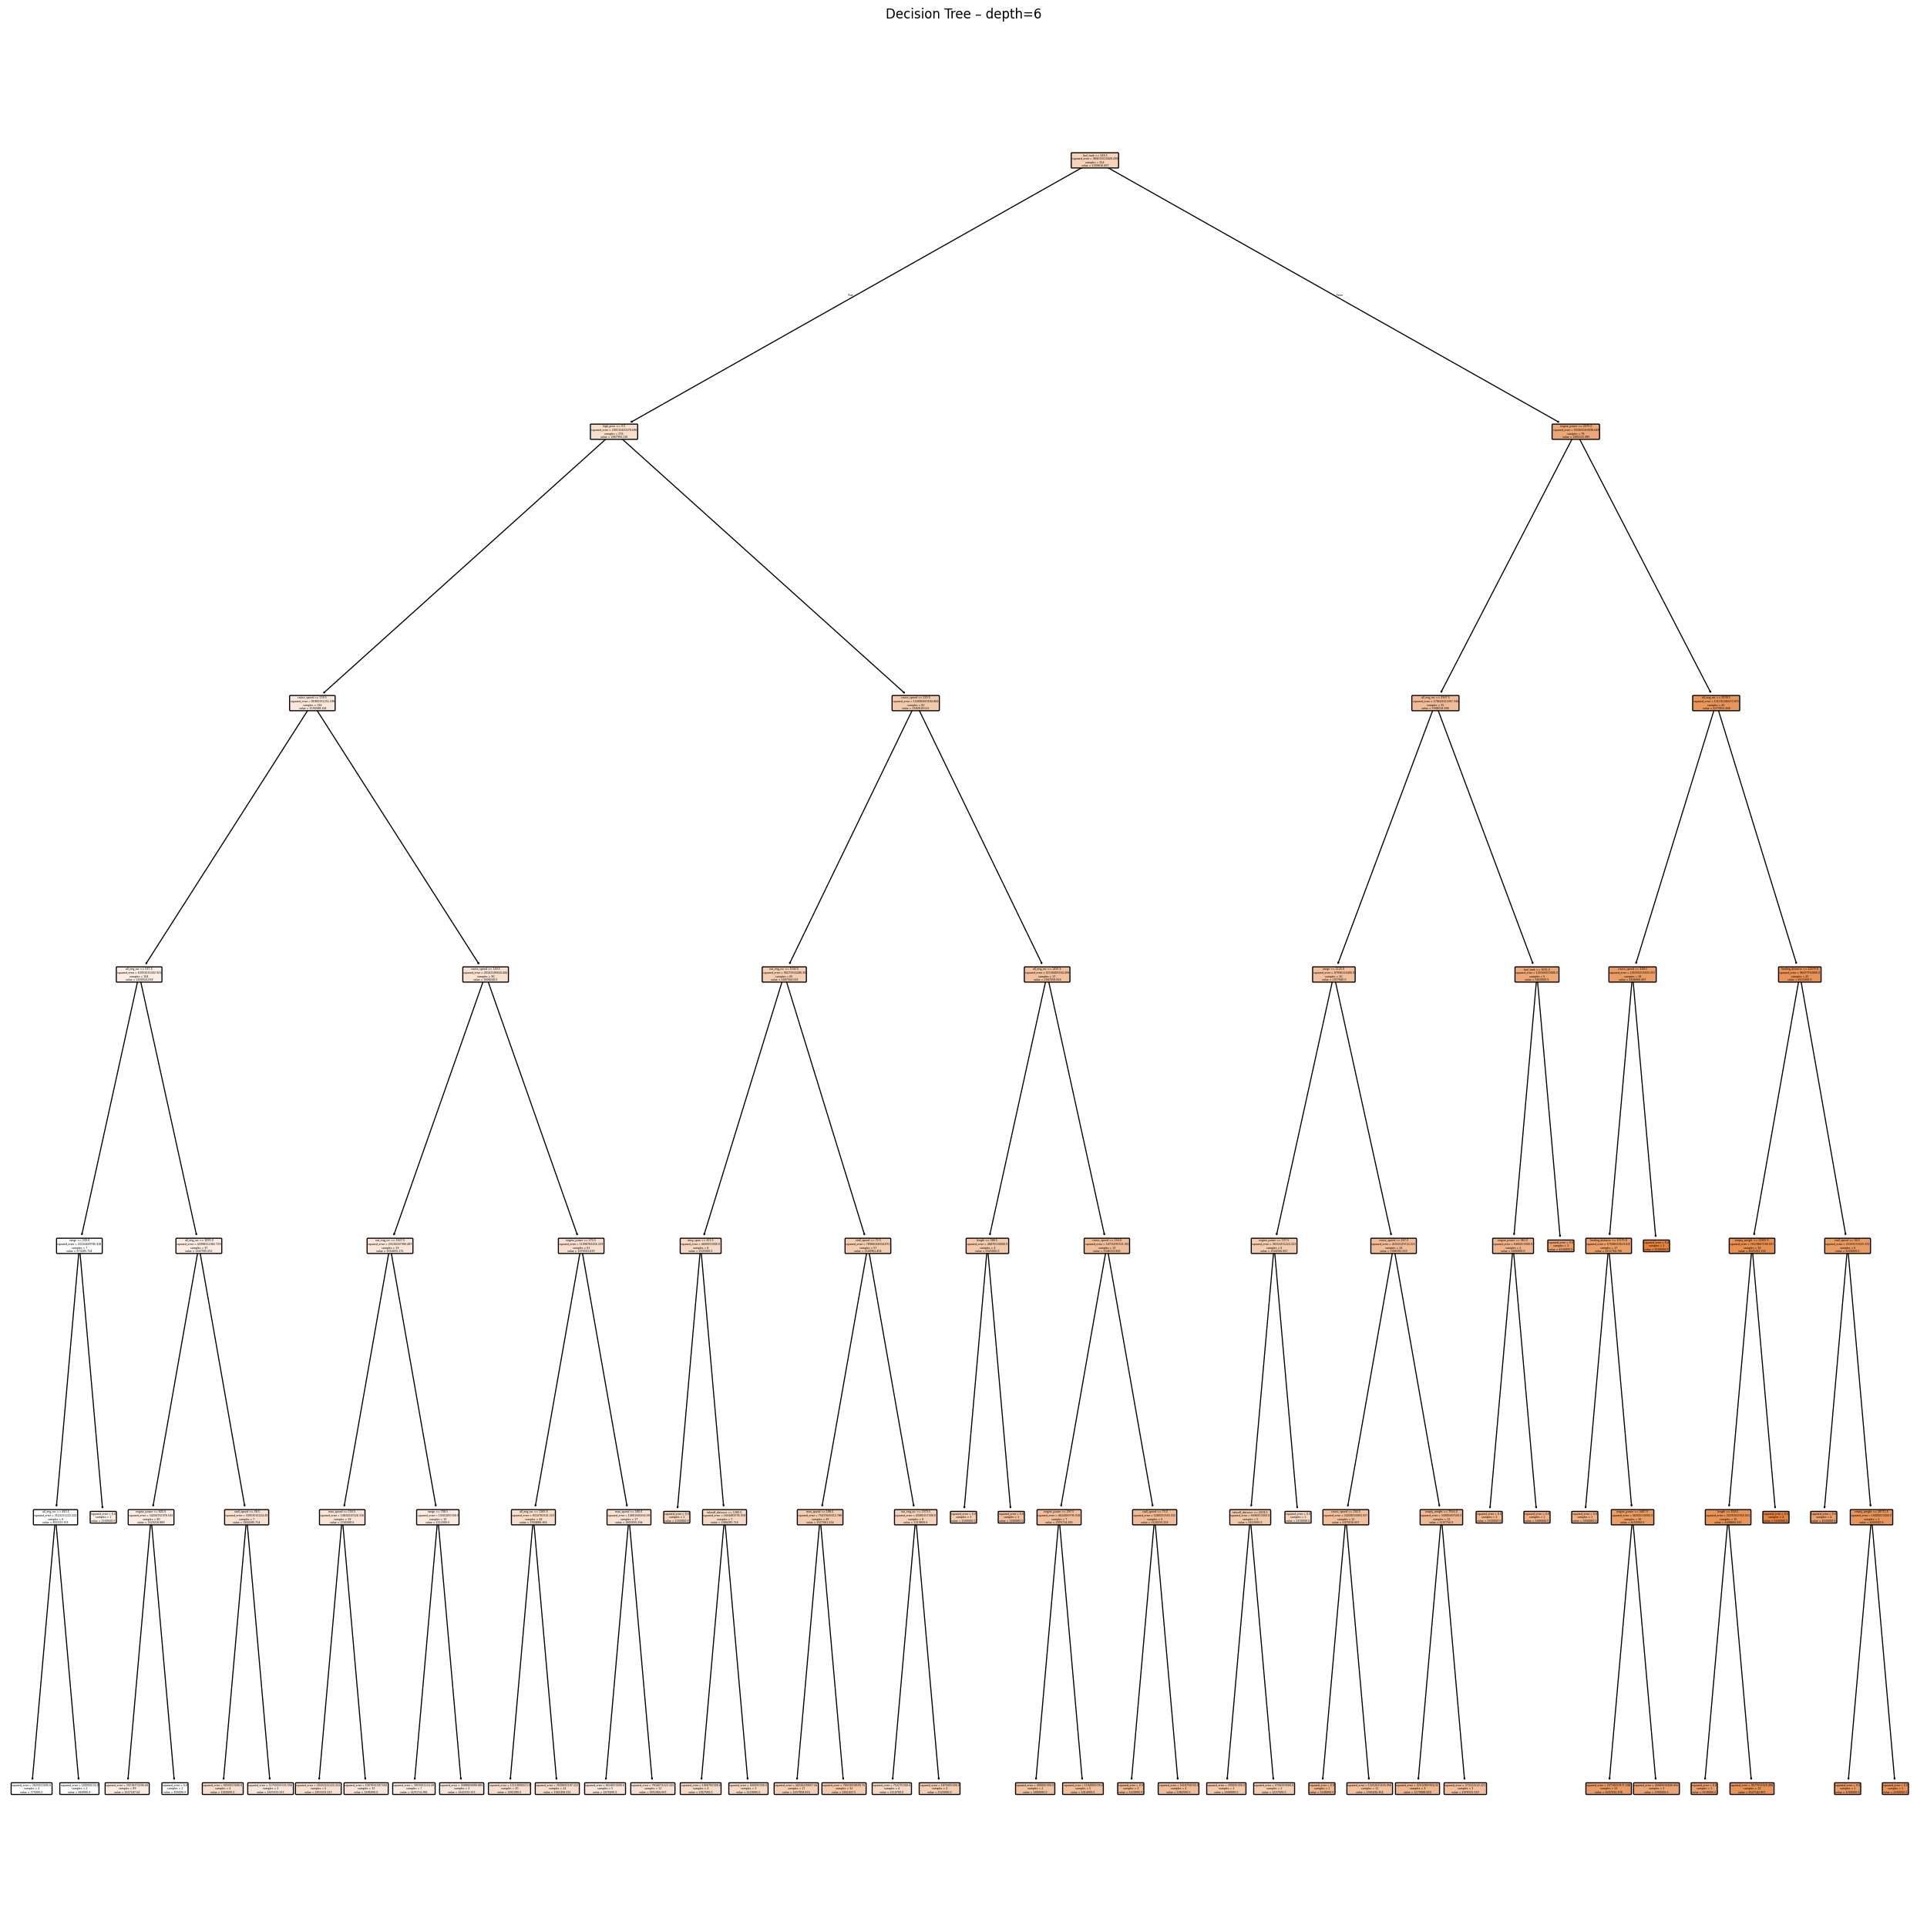

In [79]:
# Compute MSE and RMSE for the pruned tree at best_depth
best_reg = DecisionTreeRegressor(max_depth=best_depth, random_state=2)
best_reg.fit(X_train, y_train)

mse  = np.mean((y_test - best_reg.predict(X_test)) ** 2)
rmse = np.sqrt(mse)

print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

# plot pruned regression tree
fig, ax = plt.subplots(figsize=(32, 32))
plot_tree(best_reg,
          feature_names=feature_names,
          filled=True,
          rounded=True,
          ax=ax)
ax.set_title(f"Decision Tree – depth={best_depth}")
plt.show()

NameError: name 'G' is not defined

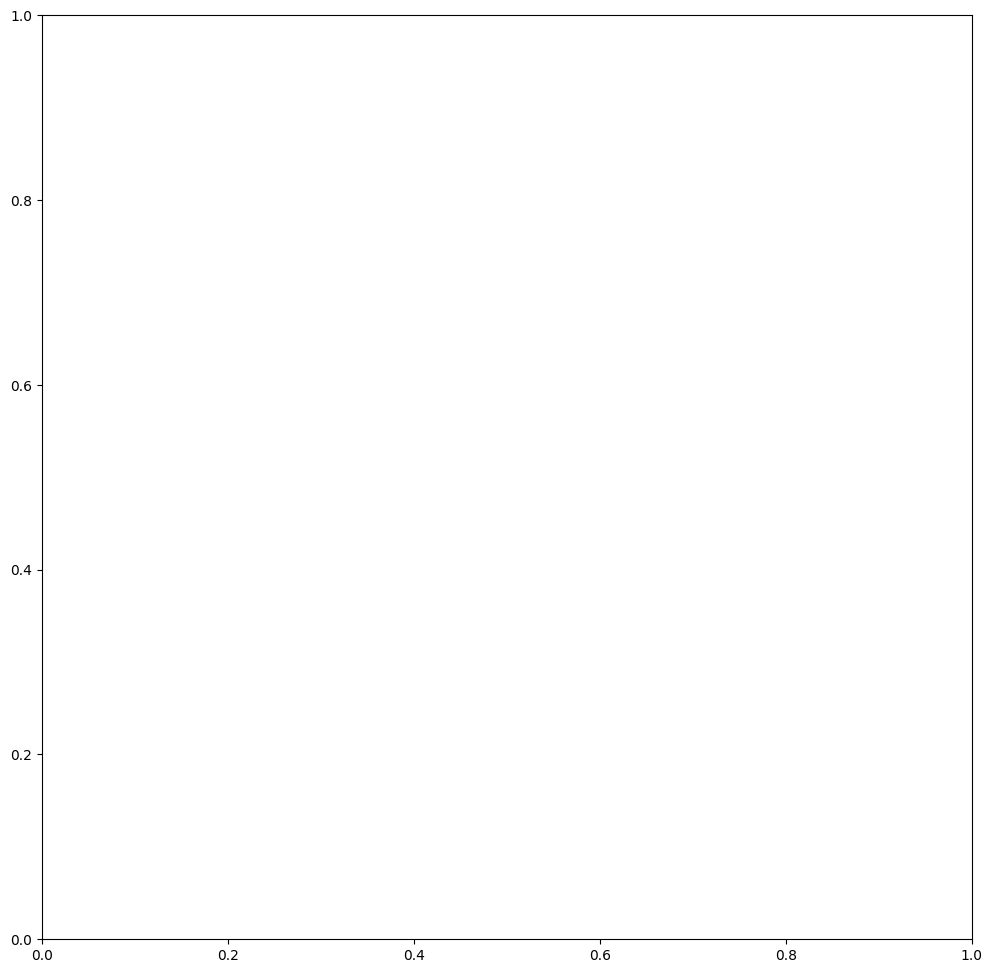

In [80]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);

### Codice ChatGPT usando GridSearchCV



Fitting 5 folds for each of 240 candidates, totalling 1200 fits
✅ Best params: {'reg__max_depth': 12, 'reg__max_features': 0.5, 'reg__min_samples_leaf': 5, 'reg__min_samples_split': 2}


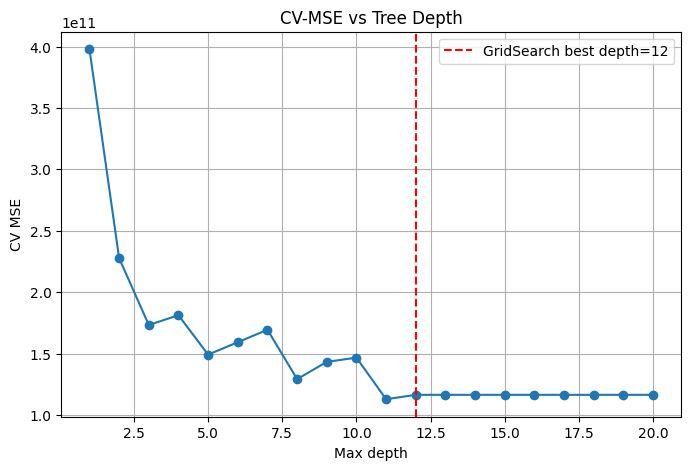

🌳 Pruned tree (depth=6) RMSE: 302885.20


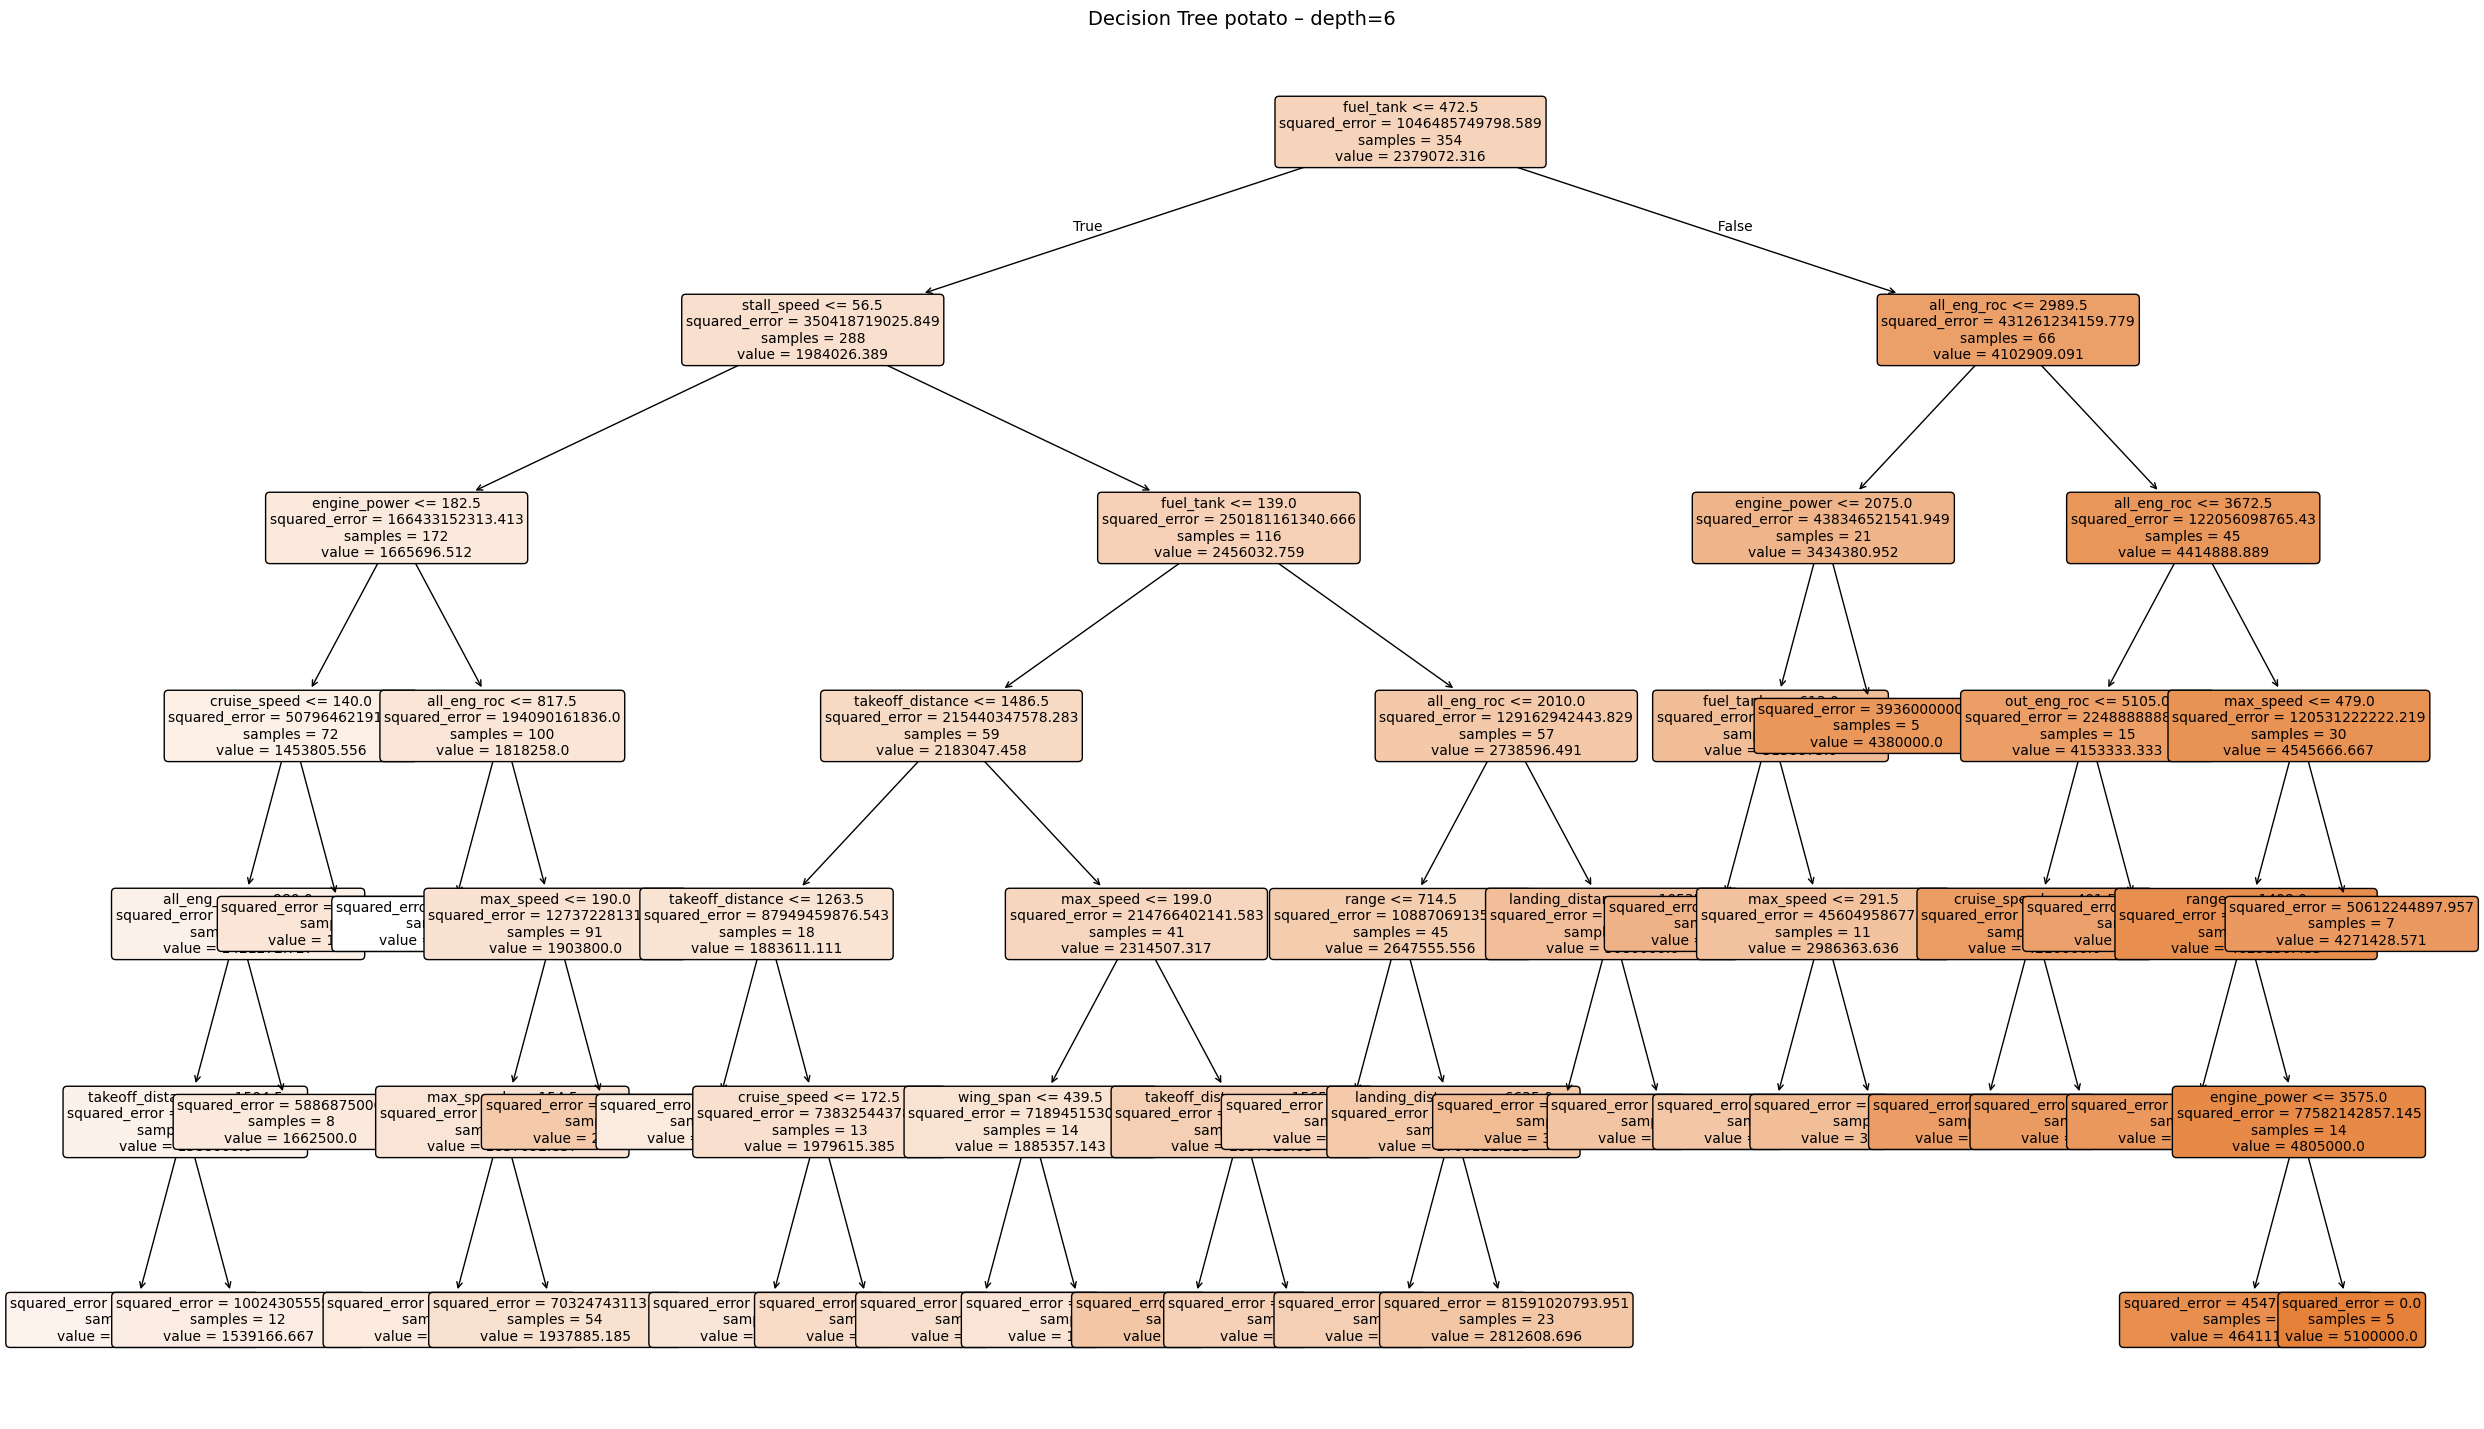

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline      import Pipeline
from sklearn.tree          import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_val_score
)
from sklearn.metrics      import mean_squared_error

# 1) Carica i dati
df = pd.read_csv('Data/aircraft_price_clean.csv')

# 2) Seleziona colonne numeriche e target
numeric_features = df.select_dtypes(include=[np.number]).columns.drop('price')
X = df[numeric_features]
y = df['price']

# 3) Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=11
)

# 4) GridSearchCV su DecisionTreeRegressor
reg_pipe = Pipeline([('reg', DecisionTreeRegressor(random_state=11))])

param_grid = {
    'reg__max_depth':        [3, 5, 8, 12, None],
    'reg__min_samples_leaf': [1, 5, 10, 20],
    'reg__min_samples_split':[2, 10, 20, 50],
    'reg__max_features':     [None, 'sqrt', 0.5]
}

grid_reg = GridSearchCV(
    reg_pipe,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_reg.fit(X_train, y_train)

print("✅ Best params:", grid_reg.best_params_)
best_params = grid_reg.best_params_

# 5) CV-MSE vs profondità
depths = list(range(1, 21))
cv_mse  = []
for d in depths:
    model_cv = DecisionTreeRegressor(
        max_depth=d,
        min_samples_leaf=best_params['reg__min_samples_leaf'],
        min_samples_split=best_params['reg__min_samples_split'],
        max_features=best_params['reg__max_features'],
        random_state=11
    )
    scores = cross_val_score(
        model_cv, X_train, y_train,
        cv=5,
        scoring='neg_mean_squared_error'
    )
    cv_mse.append(-scores.mean())

plt.figure(figsize=(8,5))
plt.plot(depths, cv_mse, marker='o')
plt.axvline(best_params['reg__max_depth'], color='red', linestyle='--',
            label=f"GridSearch best depth={best_params['reg__max_depth']}")
plt.xlabel("Max depth")
plt.ylabel("CV MSE")
plt.title("CV-MSE vs Tree Depth")
plt.legend()
plt.grid(True)
plt.show()

# 6) Scegli a occhio una profondità più interpretabile
#    (guarda il grafico e modifica questo valore di conseguenza)
best_eye_depth = 6

# 7) Addestra l’albero potato alla profondità interpretabile
pruned_tree = DecisionTreeRegressor(
    max_depth=best_eye_depth,
    min_samples_leaf=best_params['reg__min_samples_leaf'],
    min_samples_split=best_params['reg__min_samples_split'],
    max_features=best_params['reg__max_features'],
    random_state=11
)
pruned_tree.fit(X_train, y_train)

# 8) Valuta su test set
y_pred = pruned_tree.predict(X_test)
rmse  = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"🌳 Pruned tree (depth={best_eye_depth}) RMSE: {rmse:.2f}")

# 9) Plot dell’albero potato
plt.figure(figsize=(30,18))
plot_tree(
    pruned_tree,
    feature_names = X.columns,
    filled        = True,
    rounded       = True,
    fontsize      = 10,
    max_depth     = best_eye_depth
)
plt.title(f"Decision Tree potato – depth={best_eye_depth}", fontsize=14)
plt.show()


### CODICE LIBRO ISLP

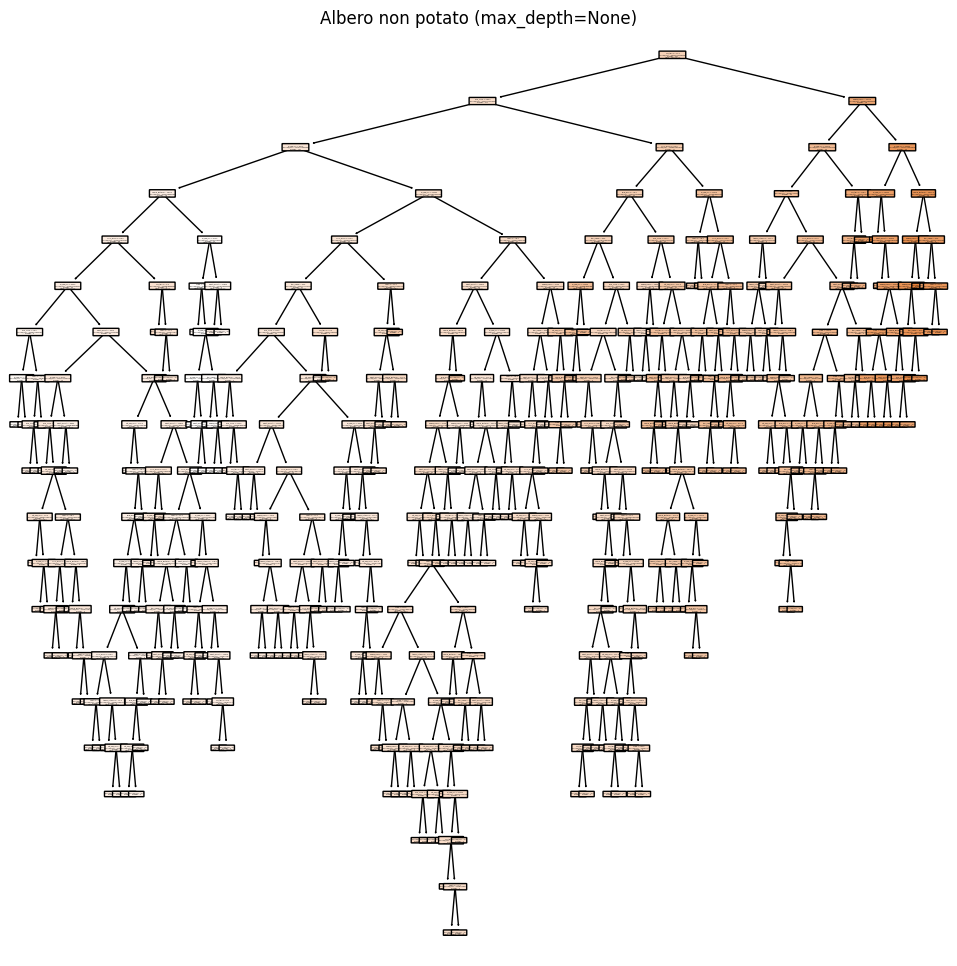

Fitting 5 folds for each of 244 candidates, totalling 1220 fits
Best ccp_alpha: 3986425947.2693987
Test set MSE (potato): 125315604784.72
Test set RMSE:          353999.44


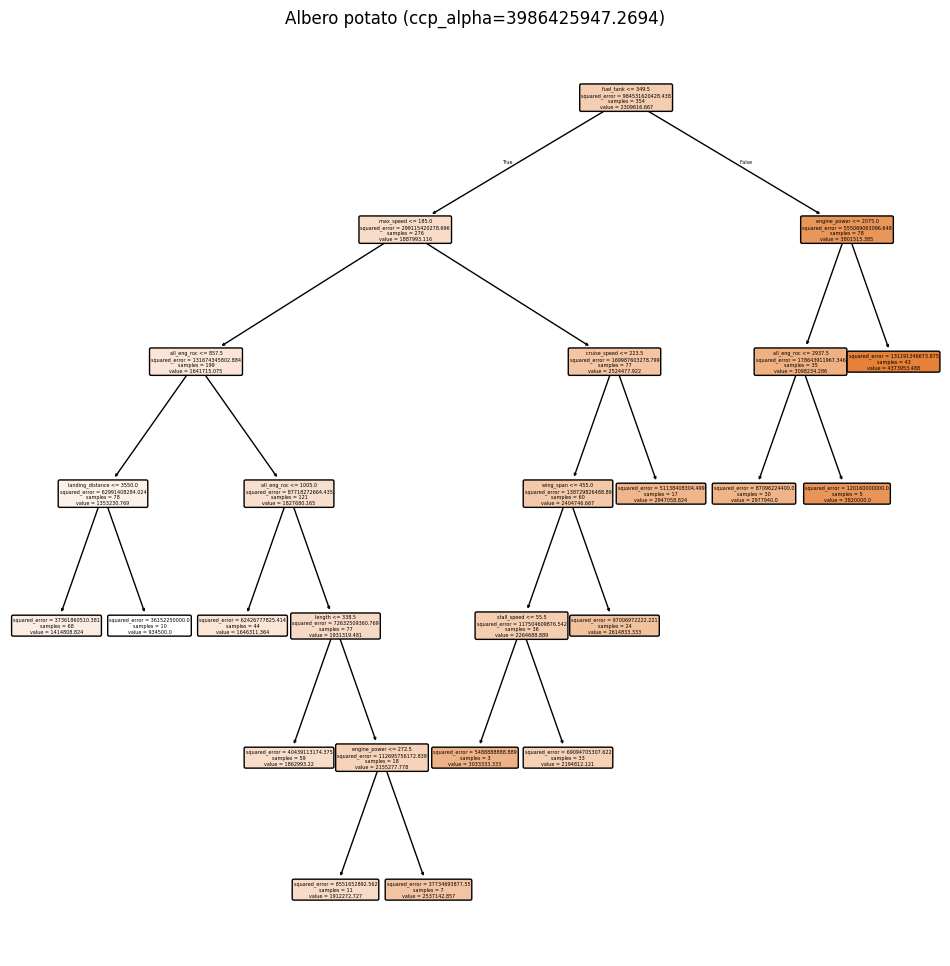

|--- fuel_tank <= 349.50
|   |--- max_speed <= 185.00
|   |   |--- all_eng_roc <= 857.50
|   |   |   |--- landing_distance <= 3550.00
|   |   |   |   |--- value: [1414808.82]
|   |   |   |--- landing_distance >  3550.00
|   |   |   |   |--- value: [934500.00]
|   |   |--- all_eng_roc >  857.50
|   |   |   |--- all_eng_roc <= 1005.00
|   |   |   |   |--- value: [1646311.36]
|   |   |   |--- all_eng_roc >  1005.00
|   |   |   |   |--- length <= 338.50
|   |   |   |   |   |--- value: [1862993.22]
|   |   |   |   |--- length >  338.50
|   |   |   |   |   |--- engine_power <= 272.50
|   |   |   |   |   |   |--- value: [1912272.73]
|   |   |   |   |   |--- engine_power >  272.50
|   |   |   |   |   |   |--- value: [2537142.86]
|   |--- max_speed >  185.00
|   |   |--- cruise_speed <= 223.50
|   |   |   |--- wing_span <= 455.00
|   |   |   |   |--- stall_speed <= 55.50
|   |   |   |   |   |--- value: [3033333.33]
|   |   |   |   |--- stall_speed >  55.50
|   |   |   |   |   |--- value: [21948

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ISLP.models import ModelSpec as MS
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

# 1) Carica dati e isola colonne numeriche + target
df = pd.read_csv('Data/aircraft_price_clean.csv')
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_numeric  = df[numeric_cols]            # include anche 'price'

# 2) Crea design matrix con MS (senza intercetta)
model_spec = MS(df_numeric.columns.drop('price'), intercept=False)
D          = model_spec.fit_transform(df_numeric)
feature_names = list(D.columns)
X          = D.values                     # numpy array
y          = df_numeric['price'].values

# 3) Train/test split (30% test come in ISLP)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

# 4) Fit albero “grezzo” e disegna subito l’albero non potato
reg0 = DecisionTreeRegressor(random_state=0)
reg0.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(12,12))
plot_tree(
    reg0,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    ax=ax
)
ax.set_title("Albero non potato (max_depth=None)")
plt.show()

# 5) Calcola il percorso di potatura (cost complexity pruning)
ccp_path = reg0.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = ccp_path.ccp_alphas, ccp_path.impurities

# rimuoviamo l’ultimo valore (albero vuoto)
ccp_alphas = ccp_alphas[:-1]

# 6) Cross‐validation su ccp_alpha per trovare il valore migliore
cv = KFold(n_splits=5, shuffle=True, random_state=10)
grid = GridSearchCV(
    DecisionTreeRegressor(random_state=0),
    param_grid={'ccp_alpha': ccp_alphas},
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best ccp_alpha:", grid.best_params_['ccp_alpha'])
best_tree = grid.best_estimator_

# 7) MSE sul test set con l’albero potato
mse_test = mean_squared_error(y_test, best_tree.predict(X_test))
print(f"Test set MSE (potato): {mse_test:.2f}")
print(f"Test set RMSE:          {np.sqrt(mse_test):.2f}")

# 8) Disegna l’albero potato
fig, ax = plt.subplots(figsize=(12,12))
plot_tree(
    best_tree,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    ax=ax
)
ax.set_title(f"Albero potato (ccp_alpha={grid.best_params_['ccp_alpha']:.4f})")
plt.show()

# 9) (opzionale) Stampa testuale dell’albero potato
from sklearn.tree import export_text
txt = export_text(
    best_tree,
    feature_names=feature_names,
    decimals=2
)
print(txt)


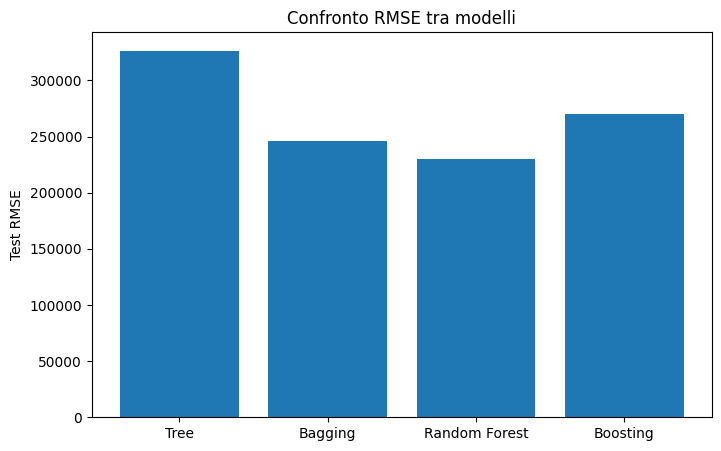

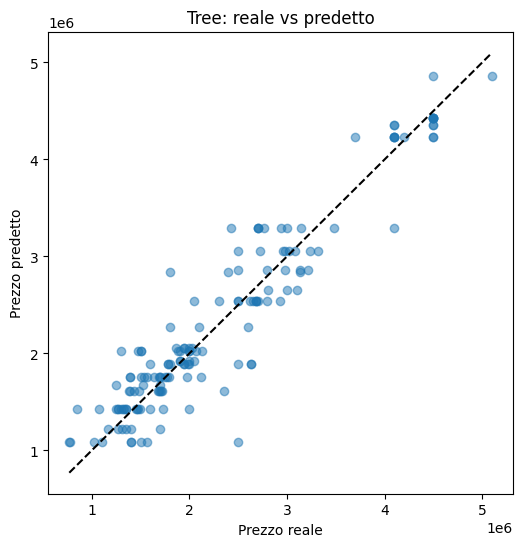

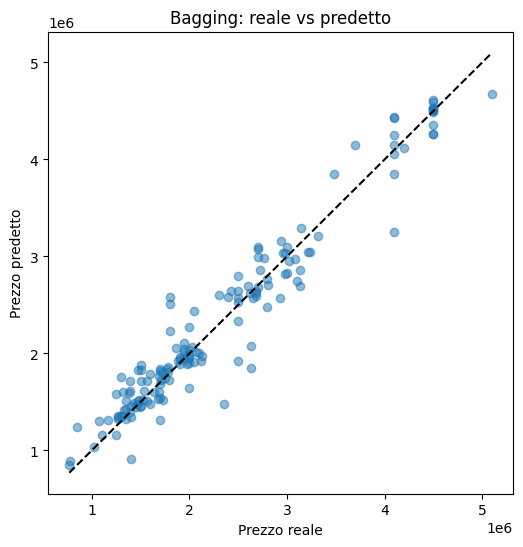

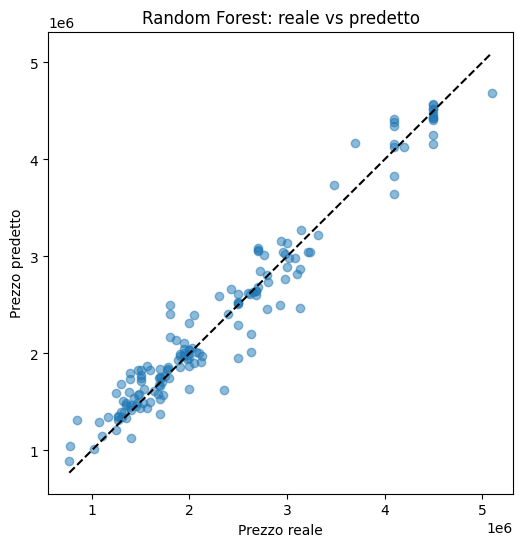

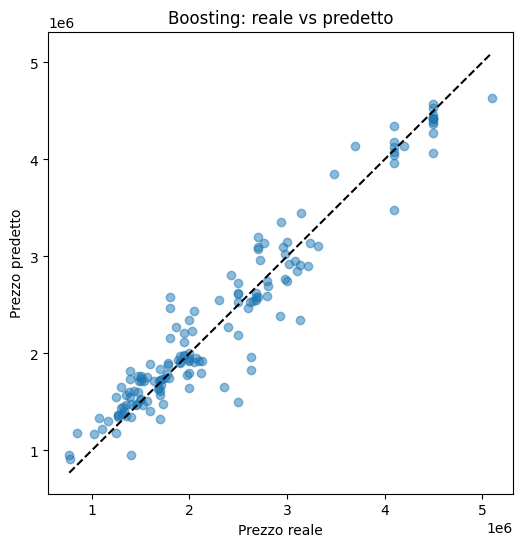

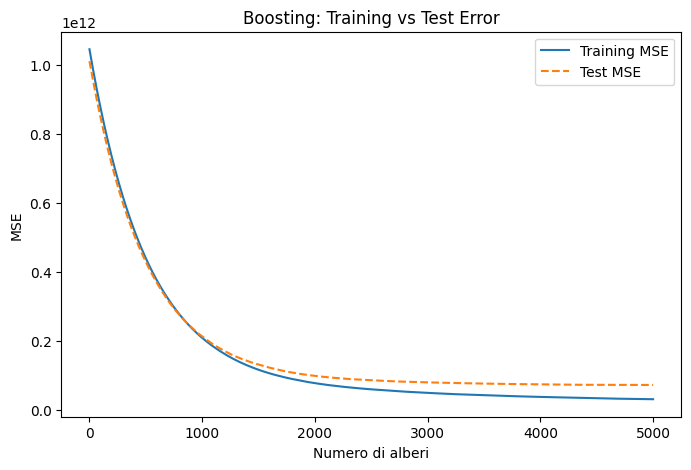

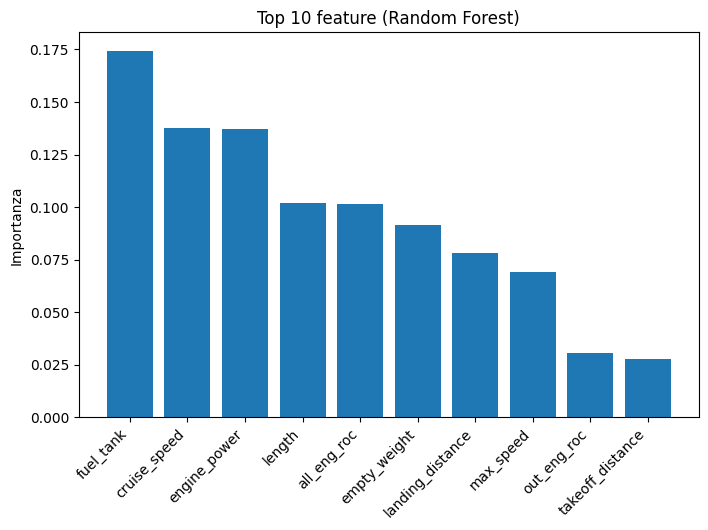

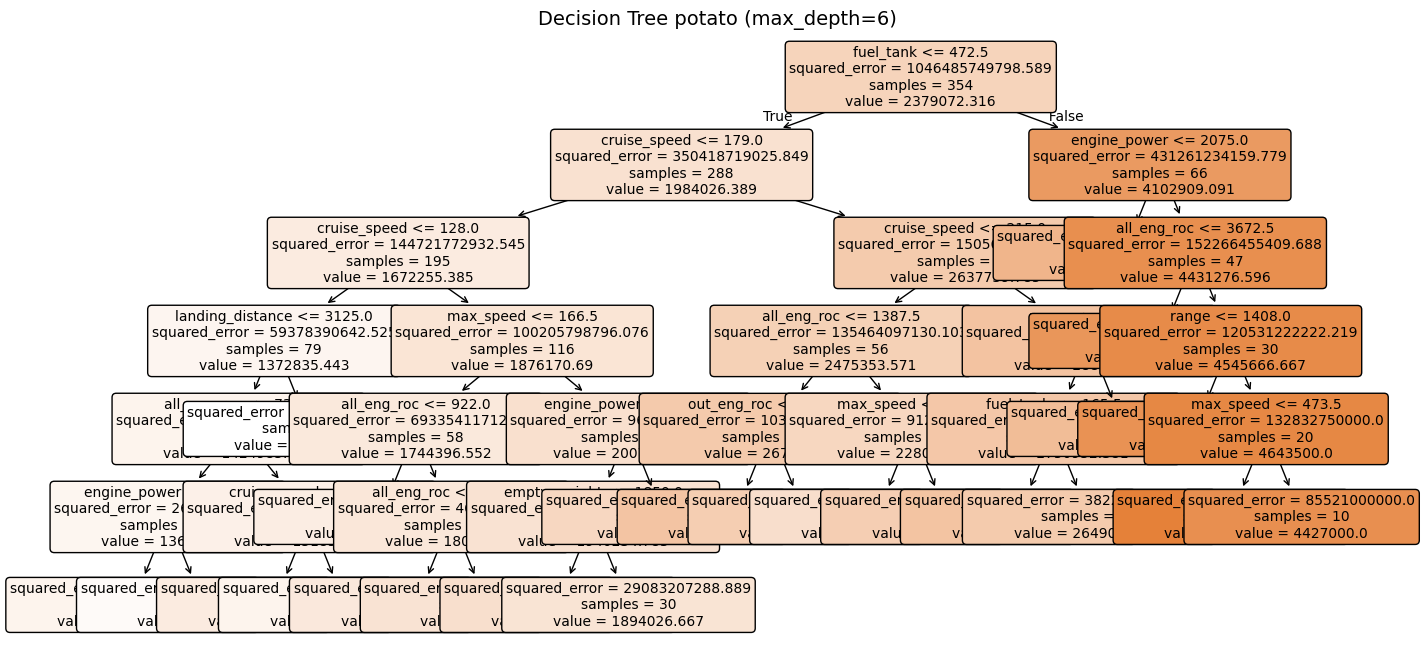

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree          import DecisionTreeRegressor, plot_tree
from sklearn.ensemble      import RandomForestRegressor as RF, GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics      import mean_squared_error

# 1) Carica i dati (aggiorna il percorso se necessario)
df = pd.read_csv('Data/aircraft_price_clean.csv')

# 2) Prepara X (solo numeriche) e y
numeric = df.select_dtypes(include=[np.number]).columns.drop('price')
X = df[numeric]
y = df['price']

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=11
)

# 4) Allena i modelli

# 4.1) Decision Tree potato “interpretabile”
tree = DecisionTreeRegressor(
    max_depth=6,
    min_samples_leaf=10,
    random_state=11
)
tree.fit(X_train, y_train)
y_tree   = tree.predict(X_test)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_tree))

# 4.2) Bagging (max_features = p)
bag = RF(
    n_estimators=100,
    max_features=X_train.shape[1],
    random_state=0
)
bag.fit(X_train, y_train)
y_bag    = bag.predict(X_test)
rmse_bag  = np.sqrt(mean_squared_error(y_test, y_bag))

# 4.3) Random Forest (max_features = √p)
rf = RF(
    n_estimators=500,
    max_features=int(np.sqrt(X_train.shape[1])),
    random_state=0
)
rf.fit(X_train, y_train)
y_rf      = rf.predict(X_test)
rmse_rf   = np.sqrt(mean_squared_error(y_test, y_rf))

# 4.4) Gradient Boosting
boost = GBR(
    n_estimators=5000,
    learning_rate=0.001,
    max_depth=3,
    random_state=0
)
boost.fit(X_train, y_train)
y_boost   = boost.predict(X_test)
rmse_boost = np.sqrt(mean_squared_error(y_test, y_boost))

# 5) --- Grafico 1: confronto RMSE ---
models = ['Tree', 'Bagging', 'Random Forest', 'Boosting']
rmses  = [rmse_tree, rmse_bag, rmse_rf, rmse_boost]

plt.figure(figsize=(8,5))
plt.bar(models, rmses)
plt.ylabel('Test RMSE')
plt.title('Confronto RMSE tra modelli')
plt.show()

# 6) --- Grafico 2: scatter Reale vs Predetto per ciascun modello ---
for name, y_pred in zip(models, [y_tree, y_bag, y_rf, y_boost]):
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    lims = [y_test.min(), y_test.max()]
    plt.plot(lims, lims, 'k--')
    plt.xlabel('Prezzo reale')
    plt.ylabel('Prezzo predetto')
    plt.title(f'{name}: reale vs predetto')
    plt.show()

# 7) --- Grafico 3: training vs test error per Boosting ---
test_err = np.zeros_like(boost.train_score_)
for i, y_hat in enumerate(boost.staged_predict(X_test)):
    test_err[i] = mean_squared_error(y_test, y_hat)

plt.figure(figsize=(8,5))
plt.plot(boost.train_score_, label='Training MSE')
plt.plot(test_err,            label='Test MSE', linestyle='--')
plt.xlabel('Numero di alberi')
plt.ylabel('MSE')
plt.title('Boosting: Training vs Test Error')
plt.legend()
plt.show()

# 8) --- Grafico 4: Feature importances (Random Forest) ---
imp = pd.Series(rf.feature_importances_, index=X.columns)
top10 = imp.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
plt.bar(top10.index, top10.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Importanza')
plt.title('Top 10 feature (Random Forest)')
plt.show()

# 9) --- Plot dell'albero potato per interpretabilità ---
plt.figure(figsize=(16,8))
plot_tree(
    tree,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=6
)
plt.title('Decision Tree potato (max_depth=6)', fontsize=14)
plt.show()
